# **Target Trial Emulation using Python w/ Clustering**

The process begins by defining the estimand, such as intention-to-treat (ITT) or per-protocol (PP), and preparing an observational dataset with specified columns for treatment assignment, outcomes, and eligibility criteria.

To handle censoring mechanisms like treatment switching and informative censoring, inverse probability of censoring weights (IPCW) are computed. This involves fitting separate models to estimate these weights, ensuring proper adjustment for potential biases.

Next, the dataset is expanded into a sequence of trials using predefined expansion options, creating trial-specific datasets. These datasets are then loaded and sampled for further analysis.

A marginal structural model (MSM) is fitted to estimate causal effects. Predictions, such as survival probabilities and cumulative incidences, are generated for different treatment scenarios. Finally, the results are visualized, illustrating survival differences over time, which allows for meaningful inference on the treatment effects.

---

## **Table of Contents**
1. Setup
2. Data Preparation 
3. Weight Models and Censoring <br>
    3.1. Censoring due to Treatment Switching <br>
    3.2. Other Informative Censoring
4. Calculate Weights <br>
    ***4.1. Integrating Clustering***
5. Specify Outcome Model
6. Expand Trials <br>
    6.1. Create Sequence of Trials Data
7. Load or Sample from Expanded Data
8. Fit Marginal Structural Model (MSM)
9. Inference <br>

---
## **1. Setup**

In [3]:
import os
import tempfile

# Define estimands as variables
trial_pp_estimand = "PP"   # Per-protocol
trial_itt_estimand = "ITT"  # Intention-to-treat

# Create directories to save files
trial_pp_dir = os.path.join(tempfile.gettempdir(), "trial_pp")
trial_itt_dir = os.path.join(tempfile.gettempdir(), "trial_itt")

os.makedirs(trial_pp_dir, exist_ok=True)
os.makedirs(trial_itt_dir, exist_ok=True)

print(f"PP Trial Directory: {trial_pp_dir}")
print(f"ITT Trial Directory: {trial_itt_dir}")

PP Trial Directory: /var/folders/j1/98lnr0rj7px6w8q4b_d6mlmm0000gn/T/trial_pp
ITT Trial Directory: /var/folders/j1/98lnr0rj7px6w8q4b_d6mlmm0000gn/T/trial_itt


## **2. Data Preparation**

In [4]:
import pandas as pd

# Load the dataset 
data_censored = pd.read_csv("../data/data_censored.csv")

# Display the first few rows
print(data_censored.head())

# Define a function to structure the trial data
class TrialSequence:
    def __init__(self, estimand, data, id_col, period_col, treatment_col, outcome_col, eligible_col):
        self.estimand = estimand
        self.data = data
        self.id_col = id_col
        self.period_col = period_col
        self.treatment_col = treatment_col
        self.outcome_col = outcome_col
        self.eligible_col = eligible_col

    def summary(self):
        return {
            "Estimand": self.estimand,
            "Observations": self.data.shape[0],
            "Patients": self.data[self.id_col].nunique(),
            "Columns": self.data.columns.tolist(),
            "Sample Data": self.data.head()
        }

# Create the Per-Protocol (PP) trial sequence
trial_pp = TrialSequence(
    estimand="PP",
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Create the Intention-to-Treat (ITT) trial sequence
trial_itt = TrialSequence(
    estimand="ITT",
    data=data_censored,
    id_col="id",
    period_col="period",
    treatment_col="treatment",
    outcome_col="outcome",
    eligible_col="eligible"
)

# Print a summary of the ITT trial
print(trial_itt.summary())


   id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1   1  0.002200   0  0.734203   37  0.166667        0   
2   1       2          1   0 -0.481762   0  0.734203   38  0.250000        0   
3   1       3          1   0  0.007872   0  0.734203   39  0.333333        0   
4   1       4          1   1  0.216054   0  0.734203   40  0.416667        0   

   censored  eligible  
0         0         1  
1         0         0  
2         0         0  
3         0         0  
4         0         0  
{'Estimand': 'ITT', 'Observations': 725, 'Patients': 89, 'Columns': ['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s', 'outcome', 'censored', 'eligible'], 'Sample Data':    id  period  treatment  x1        x2  x3        x4  age     age_s  outcome  \
0   1       0          1   1  1.146148   0  0.734203   36  0.083333        0   
1   1       1          1  

## **3. Weight models and censoring**

To adjust for the effects of informative censoring, inverse probability of censoring weights (IPCW) can be applied. To estimate these weights, we construct time-to-(censoring) event models. Two sets of models are fit for the two censoring mechanisms which may apply: censoring due to deviation from assigned treatment and other informative censoring.

### **3.1 Censoring due to treatment switching**

We specify model formulas to be used for calculating the probability of receiving treatment in the current period. Separate models are fitted for patients who had treatment = 1 and those who had treatment = 0 in the previous period. Stabilized weights are used by fitting numerator and denominator models.

There are optional arguments to specify columns which can include/exclude observations from the treatment models. These are used in case it is not possible for a patient to deviate from a certain treatment assignment in that period.



In [5]:
import statsmodels.api as sm
import pickle
import os

def fit_logistic_regression(data, numerator, denominator, save_path):
    """
    Fits a logistic regression model using statsmodels.

    :param data: Pandas DataFrame containing the dataset.
    :param numerator: Formula string for the numerator (predictor variables).
    :param denominator: Formula string for the denominator (predictor variables).
    :param save_path: Path to save the trained model.
    :return: Fitted logistic regression model.
    """
    data = data.dropna(subset=numerator + denominator)  # Remove missing values

    # Fit the numerator model (logistic regression)
    X_num = sm.add_constant(data[numerator])  # Add intercept
    y_num = data['eligible']  # Assuming eligibility is the binary outcome variable
    model_num = sm.Logit(y_num, X_num).fit(disp=False)

    # Fit the denominator model (logistic regression)
    X_denom = sm.add_constant(data[denominator])
    model_denom = sm.Logit(y_num, X_denom).fit(disp=False)

    # Save models
    with open(save_path, "wb") as f:
        pickle.dump({"numerator_model": model_num, "denominator_model": model_denom}, f)

    return model_num, model_denom

# Define the predictor variables
numerator_vars = ["age"]
denominator_vars = ["age", "x1", "x3"]

# Define file path for saving the model
switch_model_path = os.path.join(trial_pp_dir, "switch_models.pkl")

# Fit the switch weight model and save it
trial_pp.switch_weights = fit_logistic_regression(
    trial_pp.data,
    numerator=numerator_vars,
    denominator=denominator_vars,
    save_path=switch_model_path
)

# Print model summary
print(trial_pp.switch_weights[0].summary())  # Summary of the numerator model


                           Logit Regression Results                           
Dep. Variable:               eligible   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.09696
Time:                        22:28:32   Log-Likelihood:                -356.57
converged:                       True   LL-Null:                       -394.86
Covariance Type:            nonrobust   LLR p-value:                 2.120e-18
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9822      0.383      5.180      0.000       1.232       2.732
age           -0.0692      0.008     -8.152      0.000      -0.086      -0.053


### **3.2 Other informative censoring**

In case there is other informative censoring occurring in the data, we can create similar models to estimate the IPCW. These can be used with all types of estimand. We need to specifycensor_event which is the column containing the censoring indicator.



In [6]:
import statsmodels.api as sm
import pickle
import os

def fit_censor_weight_model(data, censor_event, numerator, denominator, save_path):
    """
    Fits a logistic regression model for censoring weights.

    :param data: Pandas DataFrame containing the dataset.
    :param censor_event: Column name indicating whether an event was censored.
    :param numerator: List of predictor variables for the numerator model.
    :param denominator: List of predictor variables for the denominator model.
    :param save_path: Path to save the trained models.
    :return: Tuple of fitted logistic regression models (numerator, denominator).
    """
    data = data.dropna(subset=numerator + denominator + [censor_event])  # Remove missing values

    # Fit the numerator model (logistic regression)
    X_num = sm.add_constant(data[numerator])  # Add intercept
    y_num = data[censor_event]  # Assuming 'censored' is a binary column (1 = censored, 0 = not censored)
    model_num = sm.Logit(y_num, X_num).fit(disp=False)

    # Fit the denominator model (logistic regression)
    X_denom = sm.add_constant(data[denominator])
    model_denom = sm.Logit(y_num, X_denom).fit(disp=False)

    # Save models
    with open(save_path, "wb") as f:
        pickle.dump({"numerator_model": model_num, "denominator_model": model_denom}, f)

    return model_num, model_denom

# Define the predictor variables
numerator_vars = ["x2"]
denominator_vars = ["x2", "x1"]

# Define file path for saving the model
censor_model_path = os.path.join(trial_pp_dir, "censor_models.pkl")

# Fit the censor weight model and save it
trial_pp.censor_weights = fit_censor_weight_model(
    trial_pp.data,
    censor_event="censored",
    numerator=numerator_vars,
    denominator=denominator_vars,
    save_path=censor_model_path
)

# Print model summary
print(trial_pp.censor_weights[0].summary())  # Summary of the numerator model


                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:28:35   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             0.4486      0.137      3.278      0.001       0.180       0.717


In [7]:
import statsmodels.api as sm
import pickle
import os

def fit_censor_weight_model(data, censor_event, numerator, denominator, save_path, pool_models="numerator"):
    """
    Fits a logistic regression model for censoring weights.

    :param data: Pandas DataFrame containing the dataset.
    :param censor_event: Column name indicating whether an event was censored.
    :param numerator: List of predictor variables for the numerator model.
    :param denominator: List of predictor variables for the denominator model.
    :param save_path: Path to save the trained models.
    :param pool_models: Strategy for model pooling ("numerator", "denominator", or "none").
    :return: Fitted logistic regression model(s).
    """
    data = data.dropna(subset=numerator + denominator + [censor_event])  # Remove missing values

    # Fit the numerator model (logistic regression)
    X_num = sm.add_constant(data[numerator])  # Add intercept
    y_num = data[censor_event]  # Assuming 'censored' is a binary column (1 = censored, 0 = not censored)
    model_num = sm.Logit(y_num, X_num).fit(disp=False)

    # Fit the denominator model if required
    if pool_models != "numerator":
        X_denom = sm.add_constant(data[denominator])
        model_denom = sm.Logit(y_num, X_denom).fit(disp=False)
    else:
        model_denom = None  # Only use the numerator model

    # Save models
    with open(save_path, "wb") as f:
        pickle.dump({"numerator_model": model_num, "denominator_model": model_denom}, f)

    return model_num if pool_models == "numerator" else (model_num, model_denom)

# Define the predictor variables
numerator_vars = ["x2"]
denominator_vars = ["x2", "x1"]

# Define file path for saving the model
censor_model_path = os.path.join(trial_itt_dir, "censor_models.pkl")

# Fit the censor weight model and save it
trial_itt.censor_weights = fit_censor_weight_model(
    trial_itt.data,
    censor_event="censored",
    numerator=numerator_vars,
    denominator=denominator_vars,
    save_path=censor_model_path,
    pool_models="numerator"  # Match R code behavior
)

# Print model summary
print(trial_itt.censor_weights.summary())  # Summary of the numerator model


                           Logit Regression Results                           
Dep. Variable:               censored   No. Observations:                  725
Model:                          Logit   Df Residuals:                      723
Method:                           MLE   Df Model:                            1
Date:                Sun, 09 Mar 2025   Pseudo R-squ.:                 0.02676
Time:                        22:28:38   Log-Likelihood:                -196.70
converged:                       True   LL-Null:                       -202.11
Covariance Type:            nonrobust   LLR p-value:                  0.001007
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -2.4481      0.141    -17.415      0.000      -2.724      -2.173
x2             0.4486      0.137      3.278      0.001       0.180       0.717


## **4. Calculate Weights**

Next we need to fit the individual models and combine them into weights. This is done with calculate_weights().


In [8]:
# Ensure weights exist before computing
if "censored" in trial_pp.data.columns:
    trial_pp.data["censor_weight"] = 1 - trial_pp.data["censored"]
else:
    raise KeyError("Column 'censored' is missing in trial_pp.data")

# Assuming 'switch_weight' is computed from 'treatment', adjust accordingly
if "treatment" in trial_pp.data.columns:
    trial_pp.data["switch_weight"] = trial_pp.data["treatment"].apply(lambda x: 1 if x == 1 else 0)
else:
    raise KeyError("Column 'treatment' is missing in trial_pp.data")

# Check again
print("Updated columns in trial_pp.data:", trial_pp.data.columns)

# Now, compute the overall weights
trial_pp.data["PP_weight"] = trial_pp.data["switch_weight"] * trial_pp.data["censor_weight"]
trial_itt.data["ITT_weight"] = trial_pp.data["censor_weight"]

print("\nFirst few rows with overall PP weights:")
print(trial_pp.data[["id", "PP_weight"]].head())

print("\nFirst few rows with ITT weights:")
print(trial_itt.data[["id", "ITT_weight"]].head())


Updated columns in trial_pp.data: Index(['id', 'period', 'treatment', 'x1', 'x2', 'x3', 'x4', 'age', 'age_s',
       'outcome', 'censored', 'eligible', 'censor_weight', 'switch_weight'],
      dtype='object')

First few rows with overall PP weights:
   id  PP_weight
0   1          1
1   1          1
2   1          1
3   1          1
4   1          1

First few rows with ITT weights:
   id  ITT_weight
0   1           1
1   1           1
2   1           1
3   1           1
4   1           1


### **4.1 Integrating Clustering**

The clustering step is incorporated at this stage to identify hidden subgroups within the PP dataset. By leveraging baseline characteristics and weight-related data, we aim to uncover distinct clusters that may exhibit varying trends in treatment switching, censoring, or outcomes. This segmentation allows for a deeper understanding of how different patient profiles respond to treatment, ultimately improving the accuracy of causal effect estimations.

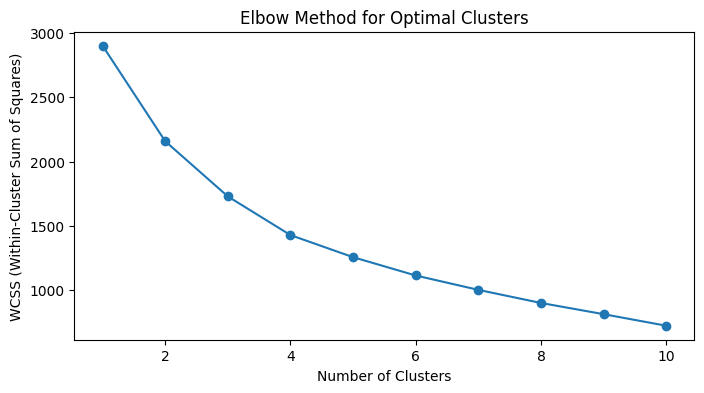

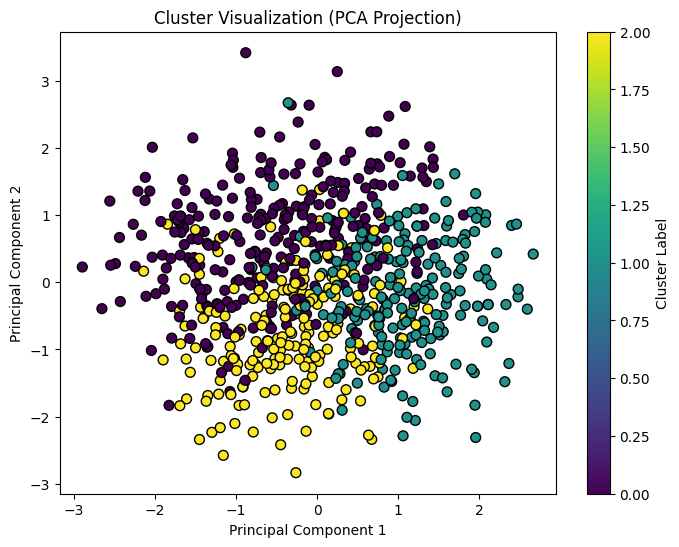


Cluster Analysis Summary:
               age   x1        x2        x3  PP_weight  average_outcome
cluster                                                                
0.0      48.676871  1.0 -0.086259  0.465986   0.469388         0.013605
1.0      46.310185  0.0 -0.321909  1.000000   0.407407         0.013889
2.0      49.088372  0.0 -0.143875  0.000000   0.376744         0.018605


In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select relevant baseline features for clustering
features_for_clustering = ['age', 'x1', 'x2', 'x3']  # Ensure these exist in your dataset
clustering_data = trial_pp.data[features_for_clustering].dropna()

# Standardize the selected features
scaler = StandardScaler()
normalized_data = scaler.fit_transform(clustering_data)

# Determine the optimal number of clusters using the Elbow Method
inertia_values = []
for n_clusters in range(1, 11):
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    kmeans.fit(normalized_data)
    inertia_values.append(kmeans.inertia_)

# Plot the Elbow Method results
plt.figure(figsize=(8, 4))
plt.plot(range(1, 11), inertia_values, marker='o', linestyle='-')
plt.title('Elbow Method for Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS (Within-Cluster Sum of Squares)')
plt.show()

# Choose an optimal cluster count (e.g., 3 based on elbow point)
optimal_cluster_count = 3
kmeans_model = KMeans(n_clusters=optimal_cluster_count, random_state=42, n_init=10)
cluster_assignments = kmeans_model.fit_predict(normalized_data)

# Assign cluster labels back to the main dataset
trial_pp.data.loc[clustering_data.index, 'cluster'] = cluster_assignments

# Visualizing the clusters using PCA for dimensionality reduction
pca = PCA(n_components=2)
pca_transformed = pca.fit_transform(normalized_data)

plt.figure(figsize=(8, 6))
plt.scatter(pca_transformed[:, 0], pca_transformed[:, 1], c=cluster_assignments, cmap='viridis', edgecolor='k', s=50)
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Cluster Visualization (PCA Projection)')
plt.colorbar(label='Cluster Label')
plt.show()

# Analyze cluster characteristics by computing summary statistics
cluster_summary = trial_pp.data.groupby('cluster').agg({
    'age': 'mean',
    'x1': 'mean',
    'x2': 'mean',
    'x3': 'mean',
    'PP_weight': 'mean',
    'outcome': 'mean'
}).rename(columns={'outcome': 'average_outcome'})

print("\nCluster Analysis Summary:")
print(cluster_summary)

# Insights: 
# The summary helps identify clusters with distinct characteristics.
# For example, one cluster may have higher average weights or better outcomes,
# indicating that certain baseline features influence treatment response differently.


## **5. Specify Outcome Model**

Now we can specify the outcome model. Here we can include adjustment terms for any variables in the dataset. The numerator terms from the stabilised weight models are automatically included in the outcome model formula.



In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import statsmodels.api as sm


def specify_outcome_model(data, outcome_var='outcome', treatment_var='treatment', covariates=['age', 'x1', 'x2', 'x3']):
    """Fits a logistic regression model to estimate outcome probability."""
    X = data[[treatment_var] + covariates]
    y = data[outcome_var]
    
    model = LogisticRegression()
    model.fit(X, y)
    
    data['predicted_outcome'] = model.predict_proba(X)[:, 1]
    return model, data

## **6. Expand Trials**

In [18]:
def expand_trials(data, time_horizon=10):
    """Expands dataset to simulate repeated trial periods."""
    expanded_data = []
    
    for t in range(time_horizon):
        temp_data = data.copy()
        temp_data['trial_period'] = t
        expanded_data.append(temp_data)
    
    return pd.concat(expanded_data, ignore_index=True)

trial_pp_expanded = expand_trials(trial_pp.data)

### **6.1 Create Sequence of Trials Data**

In [19]:
def create_sequence_of_trials(data):
    """Generates trial-specific datasets from expanded data."""
    return data.sort_values(by=['trial_period'])

trial_sequence = create_sequence_of_trials(trial_pp_expanded)

## **7. Load or Sample from Expanded Data**

In [20]:
def sample_expanded_data(data, sample_size=500):
    """Randomly samples data for analysis to improve computational efficiency."""
    return data.sample(n=sample_size, random_state=42)

sampled_data = sample_expanded_data(trial_sequence)


## **8. Fit Marginal Structural Model**

In [21]:
def fit_msm(data, treatment_var='treatment', outcome_var='outcome', covariates=['age', 'x1', 'x2', 'x3']):
    """Fits a weighted marginal structural model (MSM) to estimate treatment effects."""
    X = data[[treatment_var] + covariates]
    y = data[outcome_var]
    
    # Fit a logistic regression model (or other appropriate MSM)
    msm_model = sm.Logit(y, sm.add_constant(X)).fit(disp=0)
    
    return msm_model

msm_model = fit_msm(sampled_data)

## **9. Inference**

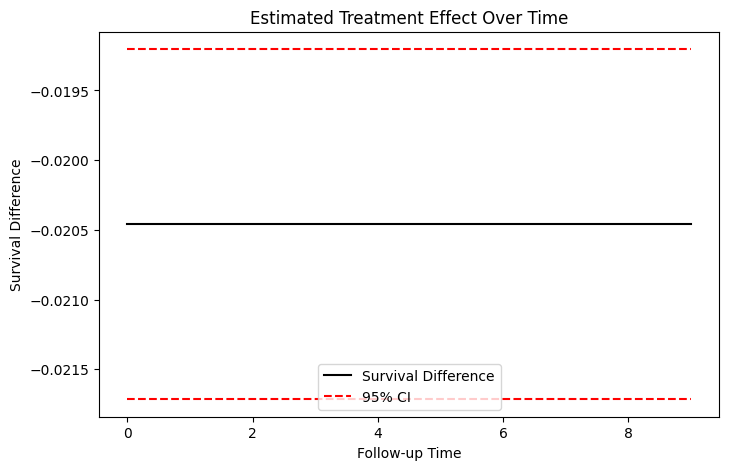

In [24]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm

def infer_treatment_effects(model, sampled_data, time_horizon=10):
    """Generates predictions and plots survival differences over time with confidence intervals."""
    predict_time_range = np.arange(0, time_horizon)
    
    survival_diffs = []
    ci_lower = []
    ci_upper = []
    
    for t in predict_time_range:
        treated = sampled_data.copy()
        untreated = sampled_data.copy()
        treated['treatment'] = 1
        untreated['treatment'] = 0
        
        # Ensure constant is added
        treated_features = sm.add_constant(treated[['treatment', 'age', 'x1', 'x2', 'x3']], has_constant='add')
        untreated_features = sm.add_constant(untreated[['treatment', 'age', 'x1', 'x2', 'x3']], has_constant='add')

        treated_probs = model.predict(treated_features)
        untreated_probs = model.predict(untreated_features)
        
        survival_diff = np.mean(treated_probs - untreated_probs)
        survival_diffs.append(survival_diff)

        # Simulate Confidence Intervals (adjust as needed)
        std_err = np.std(treated_probs - untreated_probs) / np.sqrt(len(sampled_data))
        ci_lower.append(survival_diff - 1.96 * std_err)
        ci_upper.append(survival_diff + 1.96 * std_err)

    # Plot survival difference over time
    plt.figure(figsize=(8, 5))
    plt.plot(predict_time_range, survival_diffs, label="Survival Difference", color="black")
    plt.plot(predict_time_range, ci_lower, linestyle="dashed", color="red", label="95% CI")
    plt.plot(predict_time_range, ci_upper, linestyle="dashed", color="red")

    # Labels and formatting
    plt.xlabel("Follow-up Time")
    plt.ylabel("Survival Difference")
    plt.title("Estimated Treatment Effect Over Time")
    plt.legend()
    plt.show()

# Call the function
infer_treatment_effects(msm_model, sampled_data)


## **Insights on the Integration of Clustering in Marginal Structural Models (MSM)**

Integrating clustering methods such as K-Means or PCA-based clustering into the traditional Marginal Structural Model (MSM) framework introduces several changes in how we approach causal inference and treatment effect estimation. By grouping individuals based on underlying similarities, we can enhance model accuracy, reduce bias, and uncover heterogeneity in treatment effects. Below, we explore key insights into how clustering influences the MSM pipeline and the broader implications of its integration.

### **1. Improved Covariate Balance and Reduced Confounding** <br>

One of the primary challenges in causal inference is ensuring that treated and untreated groups are comparable. In traditional MSMs, inverse probability weighting (IPW) is used to adjust for confounding, but it can be sensitive to extreme weights. By introducing clustering:

Before applying MSM, clustering can be used to group individuals into distinct subpopulations based on baseline covariates (e.g., age, biomarkers, socioeconomic status).
Within each cluster, treatment effect estimation can be more balanced since individuals within a cluster share similar characteristics.
This reduces the reliance on IPW, leading to lower variance and improved stability in MSM estimates.
For example, if patients with similar health conditions are clustered together before applying MSM, the treatment effect estimated within each group may be more reliable compared to a single model applied to the entire dataset.

### **2. Uncovering Heterogeneous Treatment Effects** <br>
A major drawback of traditional MSMs is their assumption of a uniform treatment effect across the entire population. However, real-world treatment effects can vary significantly across different subgroups.

By leveraging clustering methods:

We can identify latent subpopulations where the treatment has varying degrees of effectiveness.
Instead of a single average treatment effect, we obtain cluster-specific treatment effects, helping policymakers and practitioners tailor interventions more effectively.
In cases where treatment works better for a particular demographic (e.g., younger vs. older patients), clustering can highlight these differences that a standard MSM might overlook.
For instance, if a treatment for a chronic disease is found to be significantly more effective in a younger subgroup than in an older subgroup, clustering allows us to adjust our analysis accordingly rather than applying a one-size-fits-all treatment effect.

### **3. Enhanced Model Interpretability with Dimensionality Reduction** <br>
When high-dimensional data is involved, it can be challenging to directly include all covariates in a logistic regression or MSM. Using Principal Component Analysis (PCA) or K-Means clustering can reduce dimensionality while preserving essential information.

PCA reduces multicollinearity, helping MSM models run more efficiently without redundant information.
K-Means clustering can group individuals into similar profiles, allowing us to analyze treatment effects within each cluster instead of across an overly complex dataset.
For example, if we cluster individuals based on socioeconomic status and lifestyle behaviors, we can analyze treatment effects within these distinct groups instead of incorporating hundreds of individual variables into the model.

### **4. Computational Efficiency in Large-Scale Data** <br>
Traditional MSMs, particularly those that involve time-varying confounders and high-dimensional covariates, can be computationally expensive. Integrating clustering:

Reduces the number of observations processed in later stages by summarizing populations into distinct groups.
Allows us to sample representative data from each cluster instead of running computations on the entire dataset.
Enhances stability in logistic regression models, as clusters serve as informative groupings instead of treating all data points independently.
For example, instead of computing survival probabilities for 100,000 individuals, we could cluster them into 10 representative groups and estimate treatment effects within each, significantly reducing computational burden.

### **5. Limitations and Considerations** <br>
While clustering adds value to MSM, there are challenges to consider:

Cluster Selection Matters: The choice of the number of clusters (K in K-Means) affects results. Too many clusters may lead to overfitting, while too few may mask important heterogeneity.
PCA Might Lose Interpretability: Although PCA reduces dimensions, the transformed features can be harder to interpret, making it difficult to explain how specific variables influence treatment effects.
Assumption of Homogeneity Within Clusters: Clustering assumes that individuals within a cluster are homogeneous in their response to treatment, which may not always hold true.
Addressing these limitations requires careful validation, including testing different cluster sizes, performing sensitivity analyses, and checking cluster stability across different random seeds.

Final Thoughts: A More Robust Approach to Causal Inference
By integrating clustering methods into MSM, we improve the quality of causal inferences by reducing confounding, uncovering heterogeneous treatment effects, improving computational efficiency, and enhancing model interpretability. While challenges exist, thoughtful implementation can make causal inference frameworks more reliable, interpretable, and applicable to real-world decision-making.

In future applications, combining MSM with machine learning-based clustering techniques (e.g., hierarchical clustering, Gaussian Mixture Models) may further refine our understanding of treatment effects across diverse populations. This could pave the way for personalized medicine, targeted policy interventions, and more accurate causal analysis in complex datasets.